# Smoker and Non-smoker prediction w.r.t. Epigenetics
Epigenetics of smokers vs Non-smokers: Methylation values of selected CpG islands

The CpG sites or CG sites are regions of DNA where a cytosine nucleotide is followed by a guanine nucleotide in the linear sequence of bases along its 5' → 3' direction. CpG sites occur with high frequency in genomic regions called CpG islands (or CG islands). Cytosines in CpG dinucleotides can be methylated to form 5-methylcytosines. Enzymes that add a methyl group are called DNA methyltransferases.   
In mammals, 70% to 80% of CpG cytosines are methylated.  
Methylating the cytosine within a gene can change its expression, a mechanism that is part of a larger field of science studying gene regulation that is called epigenetics.

##### Aim:
Smoking increases the risk of many diseases, and it is also linked to blood DNA methylation changes that may be important in disease etiology.  
Through this study using epigenetics data I try to answer the effect on the CpG island by the extent of mythalation due to smoking while performing EDA  and building a ML model that uses the predisposition of mythyalation pattern in smokers to differentiate them from non smokers.  

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report
import optuna

In [83]:
data = pd.read_csv("Smoker_Epigenetic_df.csv")
data = data.drop('GSM', axis=1)
data = data.dropna(axis=0)

In [84]:
data.shape

(621, 23)

<Axes: xlabel='Age', ylabel='Count'>

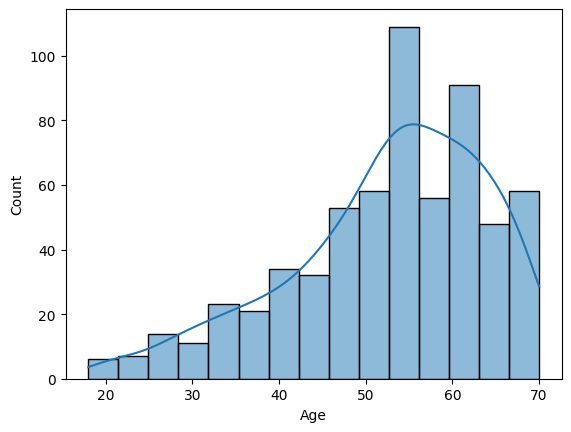

In [85]:
sns.histplot(data=data['Age'],kde=True)

In [86]:
label_encoder = LabelEncoder()
for column in ["Gender","Smoking Status"]:
    data[column] = label_encoder.fit_transform(data[column])

#### Scaling

In [157]:
scaler = MinMaxScaler() #scaling
data2 = data.drop('Smoking Status', axis=1)
data2 = pd.DataFrame(scaler.fit_transform(data2),columns=data2.columns.to_list())

In [158]:
X = data2
y = data['Smoking Status']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 65.60
Precision: 0.656
Recall: 0.656
F1-Score: 0.656
[[72 16]
 [27 10]]


In [160]:
data["Smoking Status"].value_counts()

0    428
1    193
Name: Smoking Status, dtype: int64

In [161]:
over_sampler = RandomOverSampler(random_state=42)
X, y = over_sampler.fit_resample(X, y)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBClassifier(n_estimators=100,enable_categorical=True)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 87.79
Precision: 0.877906976744186
Recall: 0.877906976744186
F1-Score: 0.877906976744186
[[64 19]
 [ 2 87]]


In [164]:
X_train.columns

Index(['Gender', 'Age', 'cg00050873', 'cg00212031', 'cg00213748', 'cg00214611',
       'cg00455876', 'cg01707559', 'cg02004872', 'cg02011394', 'cg02050847',
       'cg02233190', 'cg02494853', 'cg02839557', 'cg02842889', 'cg03052502',
       'cg03155755', 'cg03244189', 'cg03443143', 'cg03683899', 'cg03695421',
       'cg03706273'],
      dtype='object')

<BarContainer object of 22 artists>

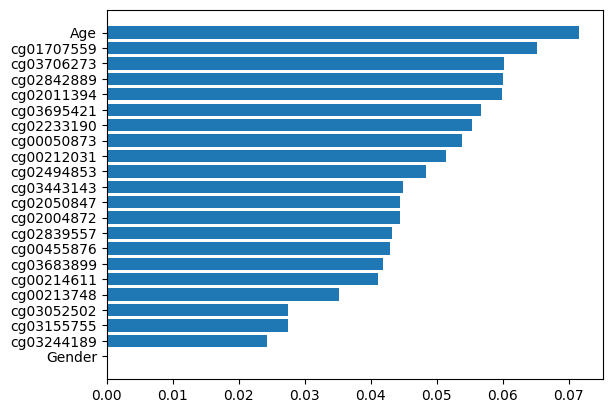

In [165]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx],xgb.feature_importances_[idx])

In [195]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
    }
    model = XGBClassifier(**param, eval_metric="logloss",enable_categorical=True)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = XGBClassifier(**best_params, eval_metric="logloss",enable_categorical=True)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

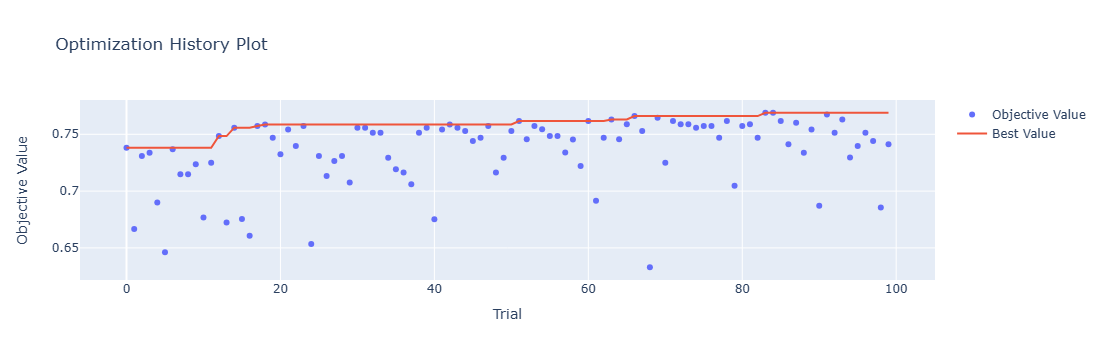

In [197]:
optuna.visualization.plot_optimization_history(study).show()

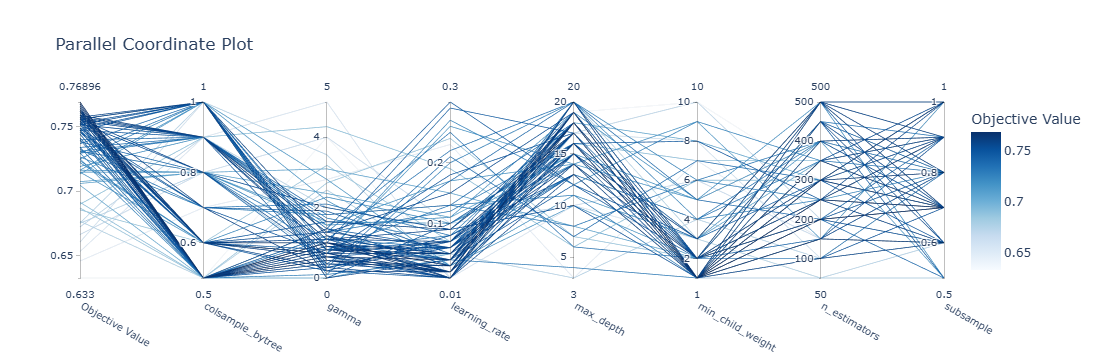

In [198]:
optuna.visualization.plot_parallel_coordinate(study).show()

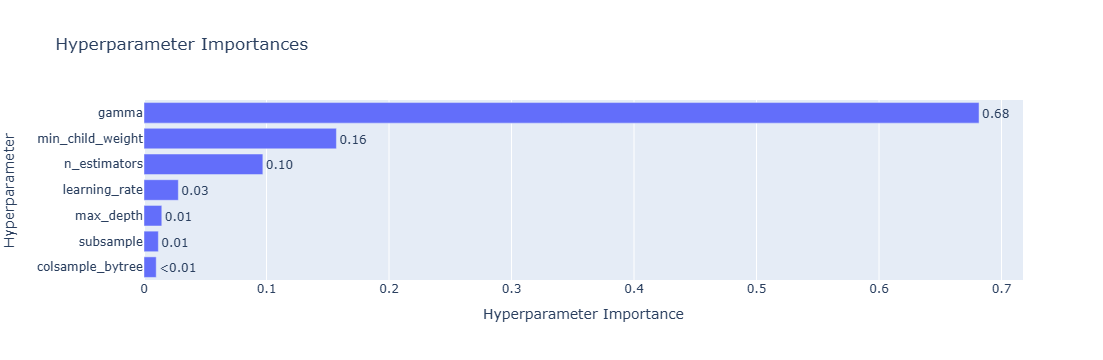

In [199]:
optuna.visualization.plot_param_importances(study).show()

#### NN

In [211]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],))) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(2, activation='softmax'))    

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5350 - loss: 0.7054 - val_accuracy: 0.5693 - val_loss: 0.6923
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5488 - loss: 0.6870 - val_accuracy: 0.5036 - val_loss: 0.6968
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6089 - loss: 0.6745 - val_accuracy: 0.5036 - val_loss: 0.6972
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 0.6669 - val_accuracy: 0.5182 - val_loss: 0.6911
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 0.6606 - val_accuracy: 0.5255 - val_loss: 0.6948
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5847 - loss: 0.6618 - val_accuracy: 0.5547 - val_loss: 0.6914
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 0.6427 - val_accuracy: 0.5109 - val_loss: 0.7010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5773 - loss: 0.6711 - val_accuracy: 0.5109 - v

In [227]:
test_accuracy

0.7383720874786377

In [233]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    units = trial.suggest_int("units", 32, 128, step=32)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    #dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = 10
    epochs = 100

    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    for _ in range(n_layers - 1):
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation="softmax"))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0,
    )

    val_accuracy = max(history.history["val_accuracy"])
    return val_accuracy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:", best_params)


n_layers = best_params["n_layers"]
units = best_params["units"]
activation = best_params["activation"]
#dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]
#batch_size = best_params["batch_size"]


final_model = Sequential()
final_model.add(Dense(units, activation=activation, input_shape=(X_train.shape[1],)))
final_model.add(Dropout(dropout_rate))
for _ in range(n_layers - 1):
    final_model.add(Dense(units, activation=activation))
    final_model.add(Dropout(dropout_rate))
final_model.add(Dense(2, activation="softmax"))

optimizer = Adam(learning_rate=learning_rate)
final_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

final_history = final_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=10,
    validation_split=0.2,
    verbose=1,
)

test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

In [ ]:
optuna.visualization.plot_parallel_coordinate(study).show()

In [ ]:
optuna.visualization.plot_param_importances(study).show()